## Random boundaries
Start by importing some packages

In [1]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import collections

In [ ]:
import time
for i in range(3600 * 60):
    time.sleep(1)
    print(i, end="\r")

We need three functions. `random_boundary` generates a boundary, `random_fourier` generates random fourier coefficients and `intersections` looks for self intersections.

In [33]:
def random_boundary(K=20,         # Number of frequencies
                    A=0.1,        # Amplitude 
                    d=1.5,        # Frequency decay parameter
                    d_func="exp", # Decay type. "exp" for exp(-d|.|), "pow" for pow(|.|, -d)
                    tol=1e-2,          # Tolerance for intersection check
                    callback = None): # For example to track number of resamples
        """
        Generates a random, non-intersecting boundary.
        """
        coef = random_fourier(K, A, d, d_func)
        coef[K] = 0
        coef[K-1] = 0.0
        coef[K+1] = 1.0
        
        if callback is not None:
            callback()
            
        # Do rejection sampling to avoid self intersections.
        if len(intersections(coef, tol)) > 0:
            return random_boundary(K, A, d, d_func, tol, callback)
        else:
            return coef

    
def random_fourier(K=20, A=0.1, d=2.0, d_func="exp"):
    """
    decay_type: "exp" or "pow" or custom lambda function with arguments |freqs|, d
    decay: positive real number.
    """
    abs_freq = np.abs(np.linspace(-K, K, 2*K+1)) # Frequencies
    rand = randn(2*K+1) + 1j * randn(2*K+1)      # Random amplitudes
    
    # Exponential decay
    if d_func == "exp":
        coef = np.exp(-d * abs_freq) * rand * A
                    
    # Power decay
    elif d_func == "pow":
        coef = (1+abs_freq)**(-d) * rand * A
                    
    # Custom made
    elif isinstance(d_func, collections.Callable):
        coef = d_func(abs_freq, d) * rand * A
    
    else:
        assert False, "Illegal decay_type."

    return coef

        
def intersections(coef, tol):
        """
        Returns list of approximate points where the boundary self-intersects
        """
        TOL = tol/100 # Tolerance for how far out on the line segment that we consider intersections.
        
        n = round(1/tol)
        K = len(coef) // 2
        
                
        freq = np.linspace(-K, K, 2*K+1)
        t = np.linspace(0, 2*np.pi, n)
        z = sum([np.exp(1j * k * t) * c for k,c in zip(freq, coef)])

        inters = []
        for i in range(n):
            for j in range(i+1,n):
                # line i:  zi(t) = z[i] + (z[i+1] - z[i])*t,  t in (0,1).
                # line j:  zj(s) = z[j+1] + dz[j]*s,  s in (0,1)
                # Want to find s,t such that zi(t) = zj(s)
                dir_i = z[(i+1)%n] - z[i] # mod n to wrap around to the start.
                dir_j = z[(j+1)%n] - z[j] 
                
                A = np.array([[np.real(dir_i), -np.real(dir_j)],
                              [np.imag(dir_i), -np.imag(dir_j)]])
                
                b = np.array([np.real(z[j] - z[i]),
                              np.imag(z[j] - z[i])])
                if np.abs(np.linalg.det(A)) > TOL:
                    par = np.linalg.solve(A, b)

                    # If they intersect, return segment coordinate.
                    if (par < 1-TOL).all() and (par > TOL).all():
                        inters.append(z[i] + par[0]*dir_i)
        return inters   
    
def remove_axes(ax):
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')

We can now generate a random boundary and plot it. The key parameters to mess around with are `A`, `d` and `d_func`.

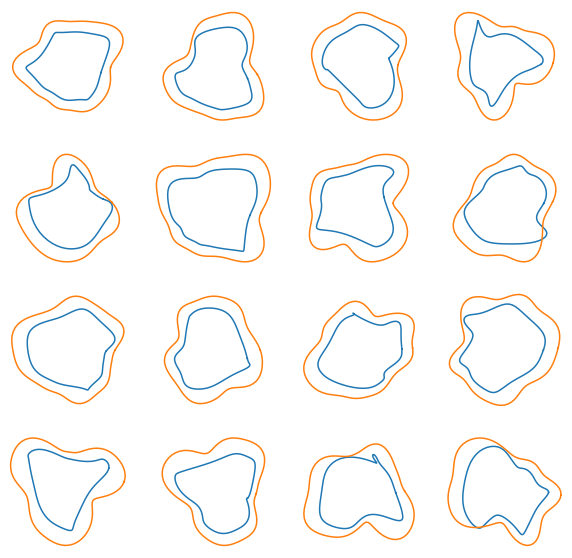

In [94]:
# Set random seed for reproducibility
np.random.seed(0)

S = 4  # Grid size for plot
K = 10 # Number of coefficients
A = 0.3 # Amplitude
d = 0.5 # Frequency decay
d_func = "exp" # Decay type

t = np.linspace(0,2*np.pi,100)  # Discretisation
freq = np.linspace(-K,K, 2*K+1) # Frequencies (-K, ..., 0, 1, ... K)

plt.figure(figsize=(10,10))
for i in range(S*S):
    
    # Generate, evaluate
    coef = random_boundary(K,A,d,d_func)
    z = sum([np.exp(1j * k * t) * c for k,c in zip(freq, coef)])
    z2 = np.exp(1j * t) * np.abs(z) * 1.3
    
    
    # Plot
    plt.subplot(S,S,i+1)
    
    # Alternative 1, use z as boundary
    plt.plot(np.real(z), np.imag(z))
    
    # Alternative 2, use as magnitude for radial offset
    plt.plot(np.real(z2), np.imag(z2))
    remove_axes(plt.gca())
    
    
    remove_axes(plt.gca())


## Random boundary conditions
Once we are happy with the boundaries, we can use the same code to generate boundary conditions. However, we may want to enforce certain restraints on the boundary conditions, such as net zero flow through the boundary. Here is some code that generate such boundary conditions:

In [80]:
def constrained_min(d, a, b, tol=1e-6):
        """Minimise x'diag(d) x subject to a'x = b.
        D is psd matrix, a vector and b constant.
        """
        n = len(a)
        pivot = None
        for i in range(n):
            if abs(a[i]) > tol:
                pivot = i
                break
        
        assert pivot is not None, "a must be nonzero"
        
        x = np.zeros((n,))
        nonpivot = np.arange(0,n)!= pivot
        
        # Divide the elements of a into a[p] and a[not p]
        ap = a[pivot]
        a = a[nonpivot][:,None]/ap # also turn into column vector.
        b = b/ap
        
        # Calculate x.
        x[nonpivot] = np.linalg.solve(np.diag(d[nonpivot]) + d[pivot]*a @ a.T, d[pivot]*b*a).flatten()               
        x[pivot] = b - x[nonpivot] @ a
        
        return x

def flow_correction(bcoef, coef, regpar):
        """Correct the total flow across the boundary so that it is zero, using 2K+1 fourier modes.
        Return list of coefficients"""
        
        # 
        K = len(coef)//2
        freq = np.linspace(-K,K,2*K+1)
        
        # Flow of different fourier bases.
        T = 2*np.pi
        flowcoef = freq * bcoef # Flow accross boundary of each fourier basis.
        
        
        # Create minimisation problem.
        a = np.hstack([np.real(flowcoef), -np.imag(flowcoef)])
        b = -np.real(np.sum(flowcoef * coef))
        d = (1+np.abs(freq))**regpar
        d = np.hstack([d,d])
        
        # Create correction, return coefficients
        ccoef = constrained_min(d, a, b)
        ccoef = ccoef[0:(2*K+1)] + 1j * ccoef[(2*K+1):] # Turn into complex valued.
        
        return ccoef # Return coefficients.

29.251339092359903
6.700369425960417e-17


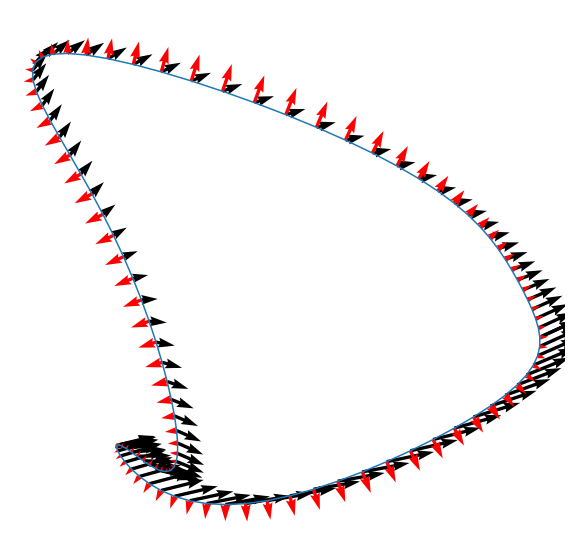

In [88]:
# Generate, evaluate
bcoef = random_boundary(K, A, d, d_func)
coef = random_fourier(K, A, d, d_func)    
coef += flow_correction(bcoef, coef, regpar=1.0)


z = sum([np.exp(1j * k * t) * c for k,c in zip(freq, bcoef)])
dz = sum([k * np.exp(1j * k * t) * c for k,c in zip(freq, bcoef)])
u = sum([np.exp(1j * k * t) * c for k,c in zip(freq, coef)])

print(np.real(np.sum(dz * u)))
print(np.real(np.sum(freq * bcoef * coef)))

plt.figure(figsize=(10,10))
plt.plot(np.real(z), np.imag(z))
plt.quiver(np.real(z), np.imag(z), np.real(u), np.imag(u))
plt.quiver(np.real(z), np.imag(z), np.real(dz), np.imag(dz), color='red', scale=50)
L = 1.3
plt.xlim([-L,L])
plt.ylim([-L,L])
remove_axes(plt.gca())